<a href="https://colab.research.google.com/github/joshiayush/tscore/blob/main/notebooks/tscore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [47]:
import os
import joblib
from pathlib import Path

In [7]:
import re
import string
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt

In [8]:
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression

In [9]:
pd.set_option("display.max_colwidth", 200)

In [10]:
df = pd.read_csv(
    "/content/drive/MyDrive/Colab Notebooks/tscore/datasets/training.1600000.processed.noemoticon.csv",
    names=['Sentiment','id','date','flag','user','SentimentText'],
    encoding="ISO-8859-1",
)

In [11]:
df.head(10)

,Sentiment,id,date,flag,user,SentimentText
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,"@LOLTrish hey long time no see! Yes.. Rains a bit ,only a bit LOL , I'm fine thanks , how's you ?"
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


In [12]:
tscore_df = df.drop(['id', 'date', 'flag', 'user'], axis=1)

In [13]:
tscore_df.head(10)

,Sentiment,SentimentText
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
5,0,@Kwesidei not the whole crew
6,0,Need a hug
7,0,"@LOLTrish hey long time no see! Yes.. Rains a bit ,only a bit LOL , I'm fine thanks , how's you ?"
8,0,@Tatiana_K nope they didn't have it
9,0,@twittera que me muera ?


In [14]:
tscore_df.shape

(1600000, 2)

In [15]:
tscore_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Sentiment      1600000 non-null  int64 
 1   SentimentText  1600000 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [16]:
tscore_df['Sentiment'].unique()

array([0, 4])

In [17]:
tscore_df['Sentiment'].replace({4: 1}, inplace=True)

In [18]:
tscore_df['Sentiment'].unique()

array([0, 1])

Below is the proportion shared by the `positive` and `negative` sentiments in the dataset.

In [19]:
tscore_df['Sentiment'].value_counts(normalize=True)

Sentiment
0    0.5
1    0.5
Name: proportion, dtype: float64

## Data Visualization of `Sentiments`

[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

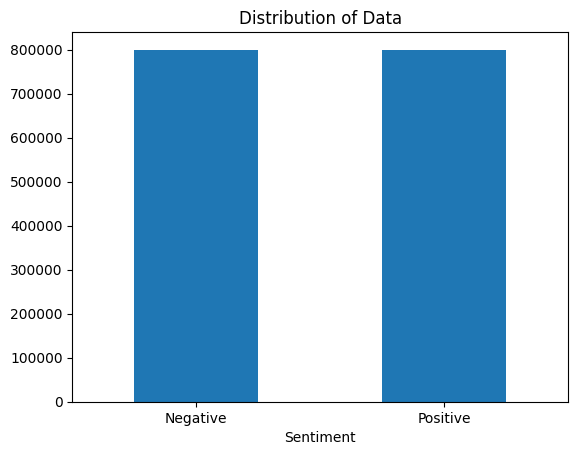

In [20]:
ax = (
    tscore_df.groupby("Sentiment")
    .count()
    .plot(kind="bar", title="Distribution of Data", legend=False)
)
ax.set_xticklabels(["Negative", "Positive"], rotation=0)

## Data Preprocessing

In [21]:
_CONTRACTIONS = {"ain't": "are not","'s":" is","aren't": "are not", "can't": "cannot","can't've": "cannot have", "'cause": "because","could've": "could have","couldn't": "could not", "couldn't've": "could not have", "didn't": "did not","doesn't": "does not", "don't": "do not","hadn't": "had not","hadn't've": "had not have", "hasn't": "has not","haven't": "have not","he'd": "he would", "he'd've": "he would have","he'll": "he will", "he'll've": "he will have", "how'd": "how did","how'd'y": "how do you","how'll": "how will", "I'd": "I would", "I'd've": "I would have","I'll": "I will", "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not", "it'd": "it would","it'd've": "it would have","it'll": "it will", "it'll've": "it will have", "let's": "let us","ma'am": "madam", "mayn't": "may not","might've": "might have","mightn't": "might not",  "mightn't've": "might not have","must've": "must have","mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not", "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not", "shan't've": "shall not have","she'd": "she would","she'd've": "she would have", "she'll": "she will", "she'll've": "she will have","should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have", "that'd": "that would","that'd've": "that would have", "there'd": "there would", "there'd've": "there would have", "they'd": "they would", "they'd've": "they would have","they'll": "they will", "they'll've": "they will have", "they're": "they are","they've": "they have", "to've": "to have","wasn't": "was not","we'd": "we would", "we'd've": "we would have","we'll": "we will","we'll've": "we will have", "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will", "what'll've": "what will have","what're": "what are", "what've": "what have", "when've": "when have","where'd": "where did", "where've": "where have", "who'll": "who will","who'll've": "who will have","who've": "who have", "why've": "why have","will've": "will have","won't": "will not", "won't've": "will not have", "would've": "would have","wouldn't": "would not", "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would", "y'all'd've": "you all would have","y'all're": "you all are", "y'all've": "you all have", "you'd": "you would","you'd've": "you would have", "you'll": "you will","you'll've": "you will have", "you're": "you are", "you've": "you have"}

In [22]:
_STOP_WORDS = set(["0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "a1", "a2", "a3", "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "affects", "after", "afterwards", "ag", "again", "against", "ah", "ain", "ain't", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appear", "appreciate", "appropriate", "approximately", "ar", "are", "aren", "arent", "aren't", "arise", "around", "as", "a's", "aside", "ask", "asking", "associated", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "being", "believe", "below", "beside", "besides", "best", "better", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "can't", "cause", "causes", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "changes", "ci", "cit", "cj", "cl", "clearly", "cm", "c'mon", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "corresponding", "could", "couldn", "couldnt", "couldn't", "course", "cp", "cq", "cr", "cry", "cs", "c's", "ct", "cu", "currently", "cv", "cx", "cy", "cz", "d", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "didn't", "different", "dj", "dk", "dl", "do", "does", "doesn", "doesn't", "doing", "don", "done", "don't", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "effect", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "empty", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "first", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "h2", "h3", "had", "hadn", "hadn't", "happens", "hardly", "has", "hasn", "hasnt", "hasn't", "have", "haven", "haven't", "having", "he", "hed", "he'd", "he'll", "hello", "help", "hence", "her", "here", "hereafter", "hereby", "herein", "heres", "here's", "hereupon", "hers", "herself", "hes", "he's", "hh", "hi", "hid", "him", "himself", "his", "hither", "hj", "ho", "home", "hopefully", "how", "howbeit", "however", "how's", "hr", "hs", "http", "hu", "hundred", "hy", "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "i'd", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "i'll", "im", "i'm", "immediate", "immediately", "importance", "important", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "invention", "inward", "io", "ip", "iq", "ir", "is", "isn", "isn't", "it", "itd", "it'd", "it'll", "its", "it's", "itself", "iv", "i've", "ix", "iy", "iz", "j", "jj", "jr", "js", "jt", "ju", "just", "k", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "know", "known", "knows", "ko", "l", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "let's", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mightn't", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "mustn't", "my", "myself", "n", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "necessary", "need", "needn", "needn't", "needs", "neither", "never", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "other", "others", "otherwise", "ou", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "possible", "possibly", "potentially", "pp", "pq", "pr", "predominantly", "present", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "s2", "sa", "said", "same", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several", "sf", "shall", "shan", "shan't", "she", "shed", "she'd", "she'll", "shes", "she's", "should", "shouldn", "shouldn't", "should've", "show", "showed", "shown", "showns", "shows", "si", "side", "significant", "significantly", "similar", "similarly", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "system", "sz", "t", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "thats", "that's", "that've", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "there's", "thereto", "thereupon", "there've", "these", "they", "theyd", "they'd", "they'll", "theyre", "they're", "they've", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "t's", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "ut", "v", "va", "value", "various", "vd", "ve", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "wa", "want", "wants", "was", "wasn", "wasnt", "wasn't", "way", "we", "wed", "we'd", "welcome", "well", "we'll", "well-b", "went", "were", "we're", "weren", "werent", "weren't", "we've", "what", "whatever", "what'll", "whats", "what's", "when", "whence", "whenever", "when's", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "where's", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "who'll", "whom", "whomever", "whos", "who's", "whose", "why", "why's", "wi", "widely", "will", "willing", "wish", "with", "within", "without", "wo", "won", "wonder", "wont", "won't", "words", "world", "would", "wouldn", "wouldnt", "wouldn't", "www", "x", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "you'd", "you'll", "your", "youre", "you're", "yours", "yourself", "yourselves", "you've", "yr", "ys", "yt", "z", "zero", "zi", "zz",])

In [23]:
class BasePreprocessorMixin(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

In [24]:
class ExpandContractions(BasePreprocessorMixin):
    _contractions_re = re.compile('(%s)' % '|'.join(_CONTRACTIONS.keys()))

    @staticmethod
    def _expand_contractions(text):
        def replace(match):
            return _CONTRACTIONS[match.group(0)]
        return ExpandContractions._contractions_re.sub(replace, text, re.IGNORECASE)

    def transform(self, X, y=None):
        for column in self.columns:
            X[column] = X[column].apply(self._expand_contractions)
        return X

In [25]:
class TextCleaner(BasePreprocessorMixin):
    @staticmethod
    def _clean_punctuations(text):
        translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
        return text.translate(translator)

    @staticmethod
    def _clean_repeating_chars(text):
        return re.sub(r'(.)1+', r'1', text)

    @staticmethod
    def _remove_mentioned(text):
        return re.sub(r'@[A-Za-z0-9]+', '', text)

    @staticmethod
    def _clean_urls(text):
        return re.sub('((www.[^s]+)|(https?://[^s]+))', '', text)

    @staticmethod
    def _clean_numeric_chars(text):
        return re.sub('\w*\d\w*', '', text)

    def _clean_text(self, text):
        text = text.lower()
        text = self._clean_repeating_chars(text)
        text = self._remove_mentioned(text)
        text = self._clean_urls(text)
        text = self._clean_punctuations(text)
        text = self._clean_numeric_chars(text)
        return text

    def transform(self, X, y=None):
        for column in self.columns:
            X[column] = X[column].apply(self._clean_text)
        return X

In [26]:
class WordTokenizer(BasePreprocessorMixin):
    def transform(self, X, y=None):
        for column in self.columns:
            X[column] = X[column].apply(word_tokenize)
        return X

In [27]:
class WordLemmatizer(BasePreprocessorMixin):
    @staticmethod
    def _get_word_net_pos(word):
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {
            "J": wordnet.ADJ,
            "N": wordnet.NOUN,
            "V": wordnet.VERB,
            "R": wordnet.ADV,
        }
        return tag_dict.get(tag, wordnet.NOUN)

    @staticmethod
    def _lemmatize_text(tokens):
        lemmatizer = nltk.WordNetLemmatizer()
        return [
            lemmatizer.lemmatize(word, WordLemmatizer._get_word_net_pos(word))
            for word in tokens
        ]

    def transform(self, X, y=None):
        for column in self.columns:
            X[column] = X[column].apply(self._lemmatize_text)
        return X

In [28]:
class StopWordsRemover(BasePreprocessorMixin):
    @staticmethod
    def _clean_stop_words(tokens):
        return [word for word in tokens if word not in _STOP_WORDS]

    def transform(self, X, y=None):
        for column in self.columns:
            X[column] = X[column].apply(self._clean_stop_words)
        return X

In [29]:
class JoinTokens(BasePreprocessorMixin):
    def transform(self, X, y=None):
        for column in self.columns:
            X[column] = X[column].apply(lambda tokens : " ".join(tokens))
        return X

In [30]:
pipeline = Pipeline(
    steps=[
        ("expand_contractions", ExpandContractions(columns=["SentimentText"])),
        ("text_cleaner", TextCleaner(columns=["SentimentText"])),
        ("word_tokenizer", WordTokenizer(columns=["SentimentText"])),
        ("word_lemmatizer", WordLemmatizer(columns=["SentimentText"])),
        ("stop_words_remover", StopWordsRemover(columns=["SentimentText"])),
        ("join_tokens", JoinTokens(columns=["SentimentText"])),
    ]
)

In [31]:
def transform_df(
    tscore_df: pd.DataFrame, force_transform: bool = False
) -> pd.DataFrame:
    transformed_df_file = Path(
        "/content/drive/MyDrive/Colab Notebooks/tscore/datasets/transformed/training.1600000.processed.noemoticon.csv"
    )
    if transformed_df_file.is_file() and not force_transform:
        return pd.read_csv(
            transformed_df_file,
            encoding="ISO-8859-1",
        )
    else:
        transformed_df = pipeline.transform(tscore_df)
        if not transformed_df_file.parents[0].is_dir():
            os.makedirs(transformed_df_file.parents[0])
        transformed_df.to_csv(transformed_df_file, encoding="ISO-8859-1", index=False)
        return transformed_df

In [32]:
tscore_df = transform_df(tscore_df)

In [33]:
tscore_df.sample(10)

,Sentiment,SentimentText
316370,0,slept amazingly woke thought west coast sigh
791024,0,marshmellow
419591,0,bought dress shoe gift hair makeup party waste
509634,0,min break decide chill break cheat phone recieved
1311372,1,learn twitter fishies
1058348,1,amazingly delicious day house eat
159038,0,snuggle cheap imitation mom man suck
508827,0,plan movie
515245,0,watch porn
508821,0,iremember aarton senna crashed san marino


In [34]:
tscore_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Sentiment      1600000 non-null  int64 
 1   SentimentText  1557349 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [35]:
tscore_df.dropna(inplace=True)

## Data Visualization

In [36]:
vocabulary = []
for row in tscore_df['SentimentText']:
    vocabulary.extend(row.split())

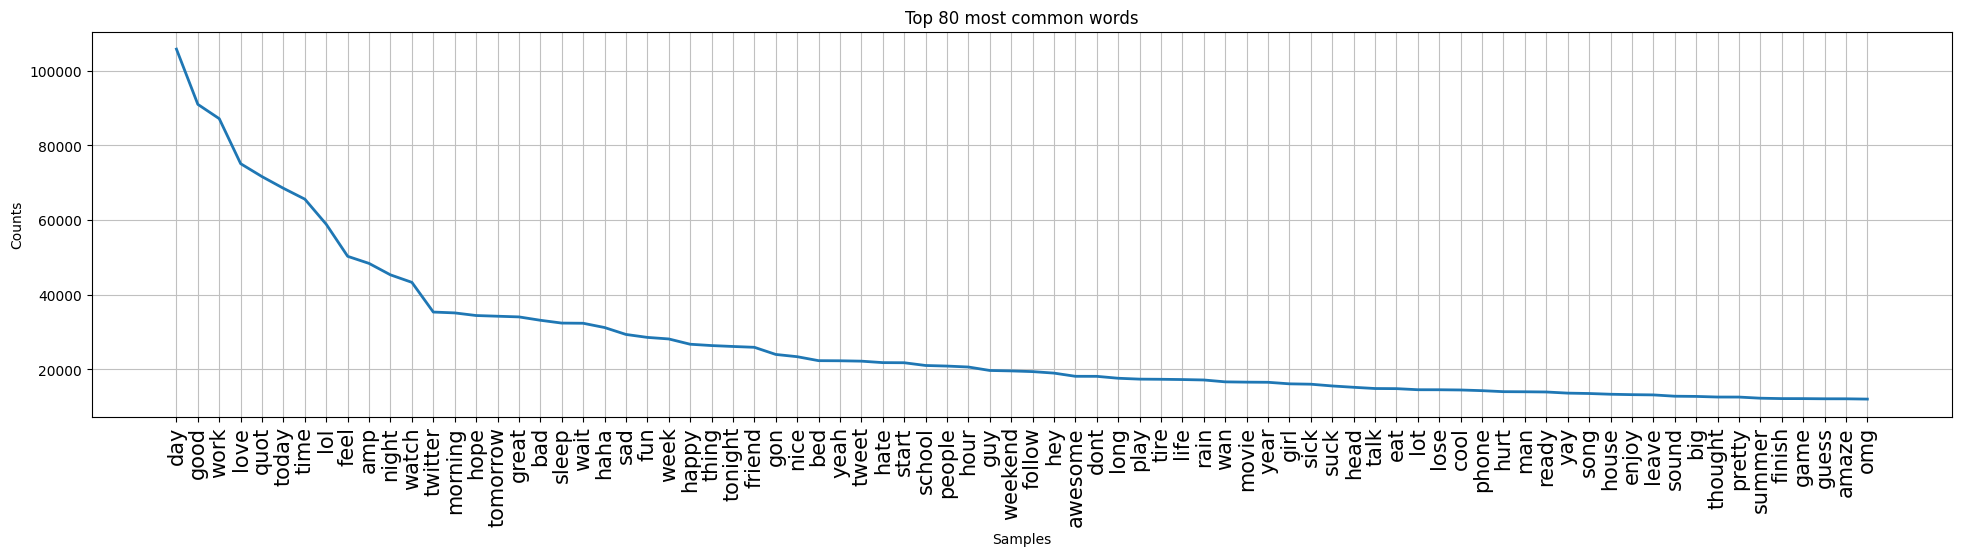

In [37]:
freq_dist = nltk.FreqDist(vocabulary)

plt.figure(figsize=(24, 5))
plt.title('Top 80 most common words')
plt.xticks(fontsize=15)

freq_dist.plot(80, cumulative=False)
plt.show()

## Train/Test Split

In [38]:
X, y = tscore_df["SentimentText"], tscore_df["Sentiment"]

In [39]:
X_train, X_test, y_train, y_test = [], [], [], []

for train_idx, test_idx in StratifiedShuffleSplit(
    n_splits=1, test_size=0.2, random_state=0
).split(X, y):
    X_train.append(X.iloc[train_idx])
    X_test.append(X.iloc[test_idx])
    y_train.append(y.iloc[train_idx])
    y_test.append(y.iloc[test_idx])

X_train = pd.concat(X_train)
X_test = pd.concat(X_test)
y_train = pd.concat(y_train)
y_test = pd.concat(y_test)

## Model Pipeline

In [40]:
clf_pipeline = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(max_features=None)),
    ('selectkbest', SelectKBest(chi2, k='all')),
    ('logistic_clf', LogisticRegression(solver='liblinear', penalty='l1', max_iter=1000)),
])

## Hyper-Parameter Tuning

In [41]:
parameters = {
    'tfidf_vectorizer__ngram_range': [(1, 2,),],
    'tfidf_vectorizer__min_df': [30,],
    'logistic_clf__C': [0.8,],
}

In [42]:
gs_clf = GridSearchCV(clf_pipeline, parameters, cv=2, n_jobs=-1)

In [43]:
gs_clf.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                                       ('selectkbest',
                                        SelectKBest(k='all',
                                                    score_func=<function chi2 at 0x7a31b9da2c20>)),
                                       ('logistic_clf',
                                        LogisticRegression(max_iter=1000,
                                                           penalty='l1',
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'logistic_clf__C': [0.8],
                         'tfidf_vectorizer__min_df': [30],
                         'tfidf_vectorizer__ngram_range': [(1, 2)]})

In [44]:
gs_clf.best_estimator_.score(X_train, y_train), gs_clf.best_estimator_.score(X_test, y_test)

(0.7532063707631319, 0.7446335120557357)

In [45]:
gs_clf.best_params_

{'logistic_clf__C': 0.8,
 'tfidf_vectorizer__min_df': 30,
 'tfidf_vectorizer__ngram_range': (1, 2)}

## Save the Model

In [48]:
joblib.dump(gs_clf.best_estimator_, 'tscore.joblib')

['tscore.joblib']